In [1]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cpu


In [2]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

In [51]:
# tacotron2

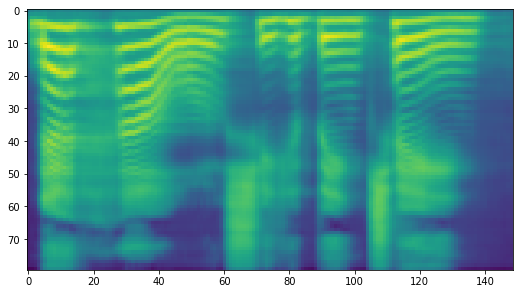

In [4]:
text = "ni hao, wo shi hu bing cheng"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, attention = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())

Using cache found in /home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'co

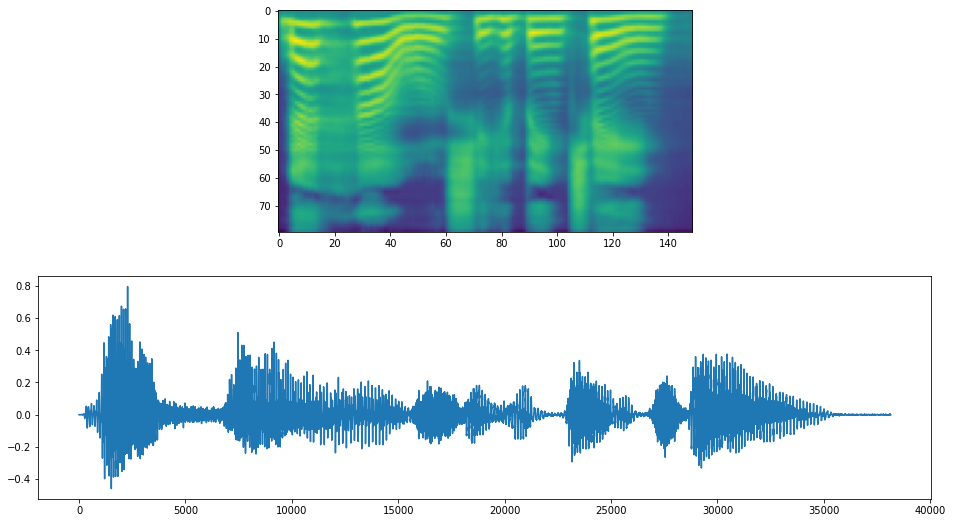

In [5]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)

# 初步训练/单说话人少量句子

In [6]:
# %load_ext autoreload
# %autoreload 2

In [7]:
# import utils.dataset
from utils.dataset import AiShell3PersonDataset, MelLoaderGenerator, RawLoaderGenerator, AiShell3Dataset

In [8]:
from pypinyin import lazy_pinyin

In [9]:
from torchaudio.pipelines._tts.utils import _get_chars
labels = _get_chars() + ('1', '2', '3', '4', '5')

In [10]:
labels[0]

'_'

In [55]:
def raw_audio_transform(sample, sample_rate=None):
        audio = sample['audio']
        audio = torchaudio.functional.vad(audio, sample_rate, trigger_level=5)
        audio = audio / torch.abs(audio).max()*0.15
        text = sample['text']
        text = text.split(' ')
        pinyin = [text[i] for i in range(len(text)) if i%2==1]
        pinyin = ' '.join(pinyin)
        chinese = [text[i] for i in range(len(text)) if i%2==0]
        return {'audio':audio,
                'text': pinyin,
                'chinese': chinese}
sample_rate = 16000               
# dataset = AiShell3PersonDataset('/scratch/bh2283/data/data_aishell3/train/', transform=raw_audio_transform, person_id='SSB0011', sample_rate=sample_rate)
dataset = AiShell3Dataset('/scratch/bh2283/data/data_aishell3/train/', transform=raw_audio_transform, sample_rate=sample_rate)
torchaudio.save('_assets/temp.wav', dataset[0]['audio'], sample_rate)
dataset[0]

{'audio': tensor([[3.4314e-05, 3.3405e-05, 3.5468e-05,  ..., 6.0680e-04, 6.8135e-04,
          3.8347e-04]]),
 'text': 'zhua1 zhu4 hu4 lian2 wang3 lang4 chao2 ying2 lai2 xin1 de5 fa1 zhan3',
 'chinese': ['抓', '住', '互', '联', '网', '浪', '潮', '迎', '来', '新', '的', '发', '展']}

In [12]:
loaderGenerator = RawLoaderGenerator(labels, k_size=5)
loaderGenerator.version

'0.02'

In [13]:
batch_size = 8
train_set, test_set = dataset.split([1,0])
train_loader = loaderGenerator.dataloader(train_set, batch_size=batch_size)
len(train_set), len(test_set)

(63262, 0)

测试随机提取几组数据

In [14]:
steps = 3
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    steps -= 1

torch.Size([8, 76078]) torch.Size([8, 95])
torch.Size([8, 63167]) torch.Size([8, 60])
torch.Size([8, 104428]) torch.Size([8, 110])


测试sort后是否顺序正常，听一下音频和文字是否相符

In [15]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    # sample_batched['audio'][0]
    torchaudio.save('_assets/temp.wav', sample_batched['audio'][0].unsqueeze(0), sample_rate)
    print(loaderGenerator.id2label(sample_batched['target'][0]))
    print(sample_batched['target_len'])
    steps -= 1

ran2_hou4_ba3_mo2_xing2_an4_zhao4_shi2_yi1_de5_bi3_li4_da3_yin4_chu1_lai2
tensor([73, 63, 49, 45, 42, 31, 29, 26])


数据绘制mel

In [16]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
            n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
                f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
safe_log = lambda x: torch.log(x+2**(-15))

tensor(0.1500)


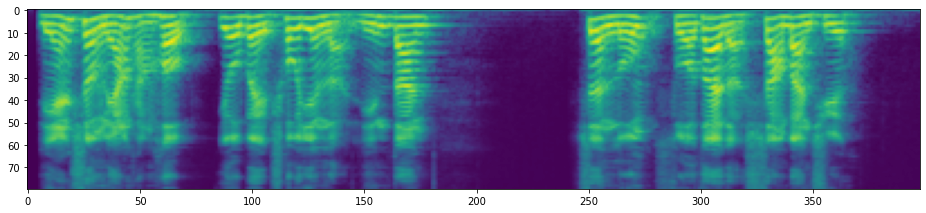

In [17]:
audio_test = dataset[91]['audio'][0]
print(torch.abs(audio_test).max())
# audio_test = audio_test / torch.abs(audio_test).max()*0.15
# audio_test = torchaudio.functional.vad(audio_test, sample_rate, trigger_level=5)
mel_test = safe_log(mel_transform(audio_test))
plt.imshow(mel_test)

In [18]:
my_tacotron2 = bundle.get_tacotron2()

In [19]:
from torch.nn.utils.rnn import pad_sequence

In [20]:
new_embedding = torch.nn.Embedding(len(labels), tacotron2.embedding.embedding_dim)

In [21]:
new_embedding.weight[:tacotron2.embedding.num_embeddings, :].shape

torch.Size([38, 512])

In [22]:
tacotron2.embedding.weight.shape

torch.Size([38, 512])

In [23]:
new_embedding.weight[:tacotron2.embedding.num_embeddings, :].data=tacotron2.embedding.weight.data

In [24]:
my_tacotron2.embedding=new_embedding

测试跑一个数据

In [25]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    steps -= 1
    print('audio', sample_batched['audio'].shape, 'target', sample_batched['target'].shape)
    audio = sample_batched['audio']
    tokens = sample_batched['target']
    audio_len = sample_batched['audio_len']
    tokens_len = sample_batched['target_len']
    # print(tokens.shape)
    # print(audio[1][:audio_len[1]].shape)
    # break
    mels_list = [safe_log(mel_transform(audio[i][:audio_len[i]])).transpose(0,1) for i in range(len(audio_len))]
    print('mel', mels_list[0].shape)
    print('tokens', loaderGenerator.id2label(tokens[0]))
    mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
    # print('mel_length', mel_length)
    max_audio_length = torch.max(mel_length)
    mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
    print('mels', mels_tensor.shape)
    org_mel, pos_mel, stop_token, attentions = my_tacotron2.forward(tokens, tokens_len, mels_tensor, mel_length)
    print('output',org_mel.shape, pos_mel.shape, stop_token.shape, attentions.shape)
    true_stop_token = torch.zeros(stop_token.shape)
    for i in range(true_stop_token.shape[0]):
        true_stop_token[i][mel_length[i]:]+=1.0
    show_id = 4
    stop_token = torch.sigmoid(stop_token)
    # print(stop_token[show_id][200:])
    for i in range(len(stop_token[show_id])):
        if stop_token[show_id][i] > 0.5:
            print('stop',i)
            break
    

audio torch.Size([8, 97392]) target torch.Size([8, 109])
mel torch.Size([381, 80])
tokens shen1_zhen4_shi4_luo2_hu2_qu1_shu1_cheng2_lu4_du1_shi4_ming2_yuan2_yi4_gao1_ceng2_zhu4_zhai2_tu1_fa1_da4_huo3
mels torch.Size([8, 80, 381])
output torch.Size([8, 80, 381]) torch.Size([8, 80, 381]) torch.Size([8, 381]) torch.Size([8, 381, 109])


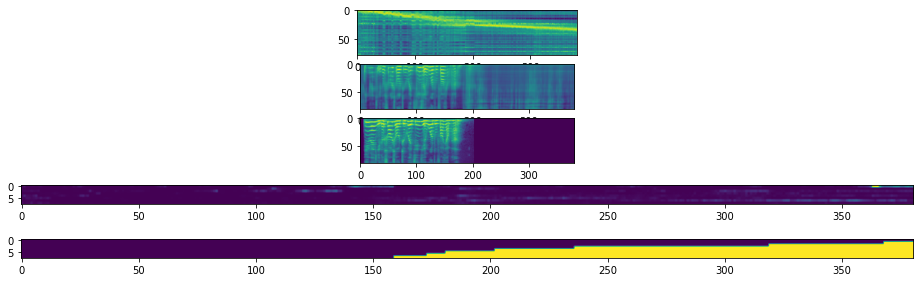

In [26]:
if __name__ =='__main__':
    fig, axs = plt.subplots(5)
    axs[0].imshow(safe_log(attentions[show_id][:, :tokens_len[show_id]]).detach().transpose(0,1).numpy())
    axs[1].imshow(pos_mel[show_id].detach().numpy())
    axs[2].imshow(mels_tensor[show_id].detach().numpy())
    axs[3].imshow(safe_log(stop_token).detach().numpy())
    axs[4].imshow(true_stop_token.detach().numpy())

## 训练

正式训练中我们需要几个loss一起训练
1. org_mel vs true_mel
2. pos_mel vs true_mel
3. sigmoid(stop_token) vs 0 and 1

那么，开始吧

In [27]:
from torchaudio.pipelines._tts.utils import _get_taco_params
from torchaudio.models.tacotron2 import Tacotron2, _get_mask_from_lengths, _Decoder, _Encoder
# _tacotron2_params=_get_taco_params(n_symbols=len(labels))
# model = Tacotron2(**_tacotron2_params)

In [28]:
# from torch import Tensor
# from typing import Tuple, List, Optional, Union
# from model.speaker_encoder import SpeakerEncoder
# class MyTacotron2(Tacotron2):
#     def __init__(
#         self,
#         labels,
#         speaker_emb_size = 256
#     ) -> None:
#         _tacotron2_params=_get_taco_params(n_symbols=len(labels))
#         org_encoder_embedding_dim = _tacotron2_params['encoder_embedding_dim']
#         _tacotron2_params['encoder_embedding_dim'] += speaker_emb_size
#         super().__init__(**_tacotron2_params)
#         self.speaker_encoder = SpeakerEncoder(_tacotron2_params['n_mels'], 256, speaker_emb_size)
#         # self.speaker_encoder = SpeakerEncoder(4,8,6)
#         self.encoder = _Encoder(org_encoder_embedding_dim, _tacotron2_params['encoder_n_convolution'], _tacotron2_params['encoder_kernel_size'])
#         self.speaker_emb_size = speaker_emb_size
    
#     def forward(
#         self,
#         tokens: Tensor,
#         token_lengths: Tensor,
#         mel_specgram: Tensor,
#         mel_specgram_lengths: Tensor,
#         speaker_emb: Optional[Tensor]=None,
#     ) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
#         r"""Pass the input through the Tacotron2 model. This is in teacher
#         forcing mode, which is generally used for training.

#         The input ``tokens`` should be padded with zeros to length max of ``token_lengths``.
#         The input ``mel_specgram`` should be padded with zeros to length max of ``mel_specgram_lengths``.

#         Args:
#             tokens (Tensor): The input tokens to Tacotron2 with shape `(n_batch, max of token_lengths)`.
#             token_lengths (Tensor): The valid length of each sample in ``tokens`` with shape `(n_batch, )`.
#             mel_specgram (Tensor): The target mel spectrogram
#                 with shape `(n_batch, n_mels, max of mel_specgram_lengths)`.
#             mel_specgram_lengths (Tensor): The length of each mel spectrogram with shape `(n_batch, )`.

#         Returns:
#             [Tensor, Tensor, Tensor, Tensor]:
#                 Tensor
#                     Mel spectrogram before Postnet with shape `(n_batch, n_mels, max of mel_specgram_lengths)`.
#                 Tensor
#                     Mel spectrogram after Postnet with shape `(n_batch, n_mels, max of mel_specgram_lengths)`.
#                 Tensor
#                     The output for stop token at each time step with shape `(n_batch, max of mel_specgram_lengths)`.
#                 Tensor
#                     Sequence of attention weights from the decoder with
#                     shape `(n_batch, max of mel_specgram_lengths, max of token_lengths)`.
#         """

#         embedded_inputs = self.embedding(tokens).transpose(1, 2) # (bs, encoder_embedding_dim, L)

#         encoder_outputs = self.encoder(embedded_inputs, token_lengths) # (bs, L, encoder_embedding_dim)

#         # My change: calculate speaker_emb, and put it inside encoder_outputs (concat)
#         if speaker_emb is None:
#             speaker_emb = self.speaker_encoder(mel_specgram.transpose(1,2), mel_specgram_lengths) # input: [bs, L, mel_in]; output: [bs, speaker_emb_size]
#         speaker_emb = speaker_emb.unsqueeze(1).expand(-1, encoder_outputs.shape[1], -1) # (bs, L, speaker_emb_size)
#         # print('xx', encoder_outputs.shape, speaker_emb.shape)
#         encoder_outputs = torch.concat([encoder_outputs, speaker_emb], -1) # (bs, L, speaker_emb_size+encoder_embedding_dim)
        
#         ## TODO: size not determinde 还需要仔细调节
#         # end this part

#         mel_specgram, gate_outputs, alignments = self.decoder(
#             encoder_outputs, mel_specgram, memory_lengths=token_lengths
#         )

#         mel_specgram_postnet = self.postnet(mel_specgram)
#         mel_specgram_postnet = mel_specgram + mel_specgram_postnet

#         if self.mask_padding:
#             mask = _get_mask_from_lengths(mel_specgram_lengths)
#             mask = mask.expand(self.n_mels, mask.size(0), mask.size(1))
#             mask = mask.permute(1, 0, 2)

#             mel_specgram.masked_fill_(mask, 0.0)
#             mel_specgram_postnet.masked_fill_(mask, 0.0)
#             gate_outputs.masked_fill_(mask[:, 0, :], 1e3)

#         return mel_specgram, mel_specgram_postnet, gate_outputs, alignments

#     @torch.jit.export
#     def infer(self, tokens: Tensor, lengths: Optional[Tensor] = None, speaker_emb: Optional[Tensor]=None) -> Tuple[Tensor, Tensor, Tensor]:
#         r"""Using Tacotron2 for inference. The input is a batch of encoded
#         sentences (``tokens``) and its corresponding lengths (``lengths``). The
#         output is the generated mel spectrograms, its corresponding lengths, and
#         the attention weights from the decoder.

#         The input `tokens` should be padded with zeros to length max of ``lengths``.

#         Args:
#             tokens (Tensor): The input tokens to Tacotron2 with shape `(n_batch, max of lengths)`.
#             lengths (Tensor or None, optional):
#                 The valid length of each sample in ``tokens`` with shape `(n_batch, )`.
#                 If ``None``, it is assumed that the all the tokens are valid. Default: ``None``

#         Returns:
#             (Tensor, Tensor, Tensor):
#                 Tensor
#                     The predicted mel spectrogram with shape `(n_batch, n_mels, max of mel_specgram_lengths)`.
#                 Tensor
#                     The length of the predicted mel spectrogram with shape `(n_batch, )`.
#                 Tensor
#                     Sequence of attention weights from the decoder with shape
#                     `(n_batch, max of mel_specgram_lengths, max of lengths)`.
#         """
#         n_batch, max_length = tokens.shape
#         if lengths is None:
#             lengths = torch.tensor([max_length]).expand(n_batch).to(tokens.device, tokens.dtype)

#         assert lengths is not None  # For TorchScript compiler

#         embedded_inputs = self.embedding(tokens).transpose(1, 2)
#         encoder_outputs = self.encoder(embedded_inputs, lengths)
#         # My change: calculate speaker_emb, and put it inside encoder_outputs (concat)
#         # speaker_emb = self.speaker_encoder(mel_specgram, mel_specgram_lengths) # input: [bs, L, mel_in]; output: [bs, out_dim]
#         if speaker_emb is None:
#             speaker_emb = torch.zeros([encoder_outputs.shape[0], self.speaker_emb_size])
#         speaker_emb = speaker_emb.unsqueeze(1).expand(-1, encoder_outputs.shape[1], -1) # (bs, L, out_dim)
#         encoder_outputs = torch.concat([encoder_outputs, speaker_emb], -1)
#         # end this part
#         mel_specgram, mel_specgram_lengths, _, alignments = self.decoder.infer(encoder_outputs, lengths)

#         mel_outputs_postnet = self.postnet(mel_specgram)
#         mel_outputs_postnet = mel_specgram + mel_outputs_postnet

#         alignments = alignments.unfold(1, n_batch, n_batch).transpose(0, 2)

#         return mel_outputs_postnet, mel_specgram_lengths, alignments

In [56]:
from model.MyTacotron2 import MyTacotron2
model = MyTacotron2(labels).to(device)

In [30]:
# if __name__ == '__main__':
#     spec = torch.randn(5, 11, 4) # bs, L, mel_in
#     lens=torch.tensor([1,2,3,4,5])
#     out = model.speaker_encoder(spec, lens) # bs, out_dim
#     print(out.shape)


In [58]:
model.parameters()

<generator object Module.parameters at 0x7ff93f4eff40>

In [78]:
params = model.parameters()
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
initial_epoch = 0
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
cos_loss = torch.nn.CosineEmbeddingLoss()
mean = lambda x: sum(x)/len(x)

In [79]:
def save_log(file_name, log, mode='a', path = './log/n1-'):
    with open(path+file_name, mode) as f:
        if mode == 'a':
            f.write('\n')
        if type(log) is str:
            f.write(log)
            print(log)
        else:
            log = [str(l) for l in log]
            f.write(' '.join(log))
            print(' '.join(log))

In [80]:
def dump_model(EPOCH, LOSS, PATH):
    torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

def save_temp(EPOCH, LOSS):
    PATH = f"./checkpoint/tacotron2/model_temp.pt"
    dump_model(EPOCH, LOSS, PATH)
    
def save_checkpoint(EPOCH, LOSS):
    PATH = f"./checkpoint/tacotron2/model_{EPOCH}_{'%.3f' % LOSS}.pt"
    dump_model(EPOCH, LOSS, PATH)

In [84]:
def train(epoch=1):
    train_loss_q = []
    test_loss_q = []
    for epoch in range(initial_epoch, epoch):
        
        batch_train_loss = []
        for i_batch, sample_batched in enumerate(train_loader):
            model.train()
            # Step 1. Prepare Data
            audio = sample_batched['audio']
            tokens = sample_batched['target']
            audio_len = sample_batched['audio_len']
            tokens_len = sample_batched['target_len']

            # Step 2. Run our forward pass
            mels_list = [safe_log(mel_transform(audio[i][:audio_len[i]])).transpose(0,1) for i in range(len(audio_len))]
            mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
            mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
            print('(mels_tensor, mel_length)', (mels_tensor.shape, mel_length.shape))
            speaker_emb = model.speaker_encoder(mels_tensor.transpose(1,2), mel_length)
            # speaker_emb = None

            org_mel, pos_mel, stop_token, _ = model.forward(tokens, tokens_len, mels_tensor, mel_length, speaker_emb)
            loss1 = mse_loss(mels_tensor, org_mel)
            loss1 += mse_loss(mels_tensor, pos_mel)

            reconstruct_speaker_emb = model.speaker_encoder(pos_mel.transpose(1,2), mel_length)
            loss2 = cos_loss(speaker_emb, reconstruct_speaker_emb, torch.ones_like(tokens_len))

            true_stop_token = torch.zeros(stop_token.shape).to(device)
            for i in range(true_stop_token.shape[0]):
                true_stop_token[i][mel_length[i]:]+=1.0
            loss3 = bce_loss(torch.sigmoid(stop_token), true_stop_token)
            
            # Step 3. Run our backward pass
            optimizer.zero_grad()
            loss = loss1 + loss2 + loss3
            loss.backward()
            optimizer.step()

            if loss.item()!=loss.item(): # if loss == NaN, break
                print('NaN hit!')
                exit()
            
            print('item', loss1.item()+loss2.item()+loss3.item())
            print('shape', loss1.shape+loss2.shape+loss3.shape)
            batch_train_loss.append(loss1.item()+loss2.item()+loss3.item())

            if i_batch % (1000 // batch_size) == 0: # log about each 1000 data
                # test_loss = test()
                test_loss = 0
                train_loss = mean(batch_train_loss)
                test_loss_q.append(test_loss)
                train_loss_q.append(train_loss)
                save_log(f'e{epoch}.txt', ['🟣 epoch', epoch, 'data', i_batch*batch_size, 
                    'lr', scheduler.get_last_lr(), 
                    'train_loss', train_loss, 'test_loss', test_loss])
                save_temp(epoch, test_loss) # save temp checkpoint
                # test_decoder(epoch, 5)
            break
            
        scheduler.step()
        save_checkpoint(epoch, mean(test_loss_q))
        save_log(f'e{epoch}.txt', ['============= Final Test ============='])
        # test_decoder(epoch, 10) # run some sample prediction and see the result

In [85]:
# def get_speaker_emb(path):
#     waveform, sr = torchaudio.load(path)
#     if sr != sample_rate:
#         waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
#     mels_tensor = safe_log(mel_transform(waveform))
#     # print(mels_tensor.shape)
#     speaker_emb = model.speaker_encoder(mels_tensor.transpose(1,2), [mels_tensor.shape[-1]])
#     # print(speaker_emb.shape)
#     return speaker_emb

# get_speaker_emb('./_assets/test.wav').shape

In [86]:
train(1)

(mels_tensor, mel_length) (torch.Size([8, 80, 335]), torch.Size([8]))
item 133.58344131708145
shape torch.Size([])
🟣 epoch 0 data 0 lr [0.005] train_loss 133.58344131708145 test_loss 0
============= Final Test =============


## 测试训练好的模型

In [37]:
processor._tokens = labels

In [38]:
from os.path import exists
def load_checkpoint(path):
    if exists(path):
        checkpoint = torch.load(path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
LOAD_PATH = './checkpoint/tacotron2/model_temp.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_checkpoint(LOAD_PATH)
model.eval()
print('')

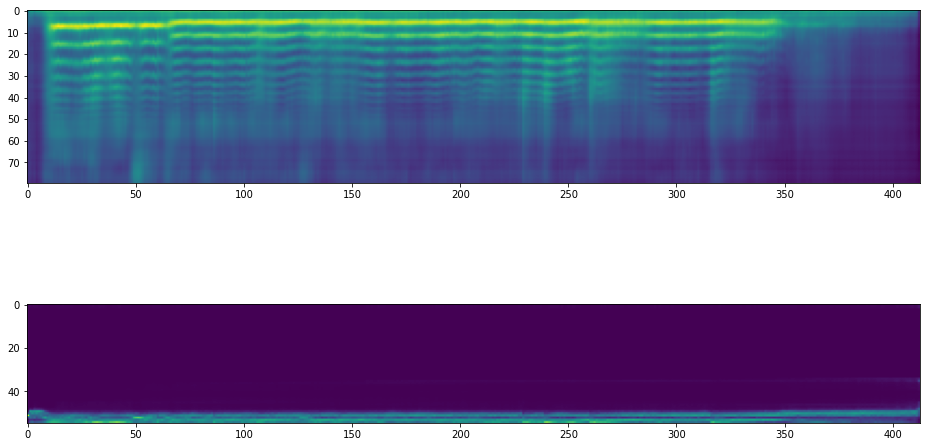

In [52]:
text = "zhua1_zhu4_hu4_lian2_wang3_lang4_chao2_ying2_lai2_xin1_de5_fa1_zhan3"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, attention = model.infer(processed, lengths, get_speaker_emb('./_assets/test.wav'))



fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.imshow(attention[0].cpu().detach().transpose(0,1))

In [53]:
spec[:,:,:200]

tensor([[[-6.2321, -4.6692, -4.5547,  ..., -4.2369, -4.1760, -4.1010],
         [-6.6674, -5.7252, -5.7109,  ..., -5.3884, -5.2624, -5.1415],
         [-6.6278, -6.0215, -6.1458,  ..., -5.4171, -5.3062, -5.1669],
         ...,
         [-8.9138, -8.7760, -8.9585,  ..., -8.1573, -8.2586, -8.3699],
         [-8.9478, -8.8967, -9.0884,  ..., -8.3137, -8.3898, -8.4981],
         [-8.9654, -8.9714, -9.1667,  ..., -8.4489, -8.5181, -8.6117]]])

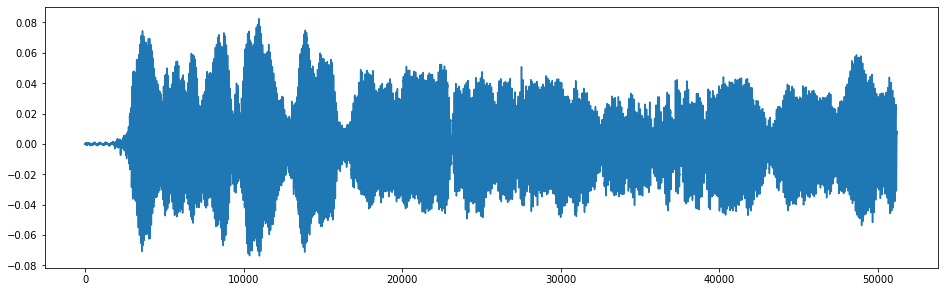

In [54]:
with torch.no_grad():
    waveforms = waveglow.infer(spec[:,:,:200])

# fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
# ax1.imshow(spec[0].cpu().detach())
plt.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)

In [48]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    steps -= 1
    print('audio', sample_batched['audio'].shape, 'target', sample_batched['target'].shape)
    audio = sample_batched['audio']
    tokens = sample_batched['target']
    audio_len = sample_batched['audio_len']
    tokens_len = sample_batched['target_len']
    # print(tokens.shape)
    # print(audio[1][:audio_len[1]].shape)
    # break
    mels_list = [safe_log(mel_transform(audio[i][:audio_len[i]])).transpose(0,1) for i in range(len(audio_len))]
    print('mel', mels_list[0].shape)
    print('tokens', loaderGenerator.id2label(tokens[0]))
    mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
    # print('mel_length', mel_length)
    max_audio_length = torch.max(mel_length)
    mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
    print('mels', mels_tensor.shape)
    speaker_emb = model.speaker_encoder(mels_tensor.transpose(1,2), mel_length)
    org_mel, pos_mel, stop_token, attentions = model.forward(tokens, tokens_len, mels_tensor, mel_length, speaker_emb)
    print('output',org_mel.shape, pos_mel.shape, stop_token.shape, attentions.shape)
    true_stop_token = torch.zeros(stop_token.shape)
    for i in range(true_stop_token.shape[0]):
        true_stop_token[i][mel_length[i]:]+=1.0
    show_id = 4
    stop_token = torch.sigmoid(stop_token)
    # print(stop_token[show_id][200:])
    for i in range(len(stop_token[show_id])):
        if stop_token[show_id][i] > 0.5:
            print('stop',i)
            break
    

audio torch.Size([7, 101507]) target torch.Size([7, 120])
mel torch.Size([397, 80])
tokens liang2_chang3_sheng4_li4_que4_bao3_le5_ta1_zheng1_qu3_gai1_ji2_bie2_di4_er4_zhang1_ao4_yun4_ru4_chang3_juan4_de5_zi1_ge2
mels torch.Size([7, 80, 397])
output torch.Size([7, 80, 397]) torch.Size([7, 80, 397]) torch.Size([7, 397]) torch.Size([7, 397, 120])
stop 153


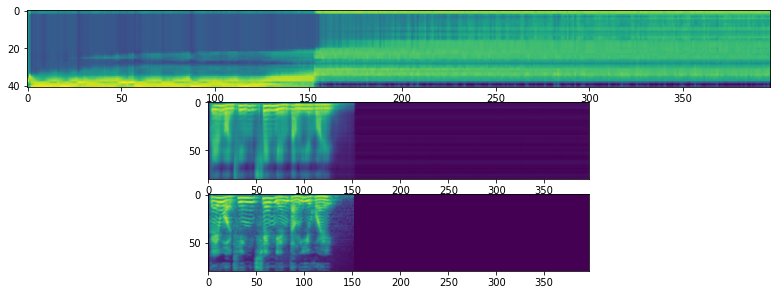

In [50]:
if __name__ =='__main__':
    fig, axs = plt.subplots(3)
    axs[0].imshow(safe_log(attentions[show_id][:, :tokens_len[show_id]]).detach().transpose(0,1).numpy())
    axs[1].imshow(pos_mel[show_id].detach().numpy())
    axs[2].imshow(mels_tensor[show_id].detach().numpy())
    # axs[3].imshow(safe_log(stop_token).detach().numpy())
    # axs[4].imshow(true_stop_token.detach().numpy())